### BOGOMOL Neural Network

This notebook was created to test the conception of BOGOMOL Convolution Networks

Importing all needed libraries

In [1]:
import os
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torchvision.transforms import v2
from datasets import load_dataset
from torchsummary import summary
from tqdm import tqdm
from src.models import ImageClassifier

Specifying CUDA if possible and setting multiprocessing start method to 'spawn', instead of 'fork', as it works better on UNIX-systems

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch._dynamo.config.suppress_errors = False

Loading cifar10 dataset

In [3]:
#cifar_ds = load_dataset('uoft-cs/cifar10')
cifar_ds = load_dataset("flwrlabs/cinic10")
cifar_train = cifar_ds['train']
cifar_val = cifar_ds['validation']
cifar_test = cifar_ds['test']
class_names = cifar_train.features['label'].names

Checking samples

0
airplane


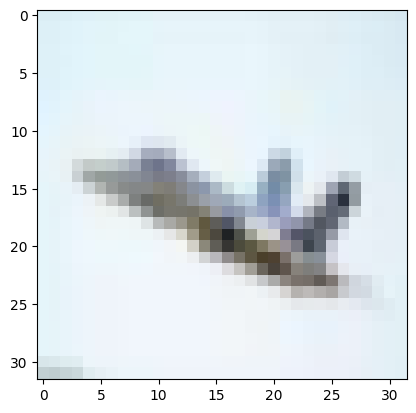

In [4]:
for i in range(1):
    sample = cifar_train[i]
    image = sample['image']
    label = sample['label']
    print(label)
    fig, ax = plt.subplots()
    print(class_names[label])
    #print(np.array(image))
    ax.imshow(image)
    plt.show()

In [5]:
transform_train = v2.Compose([
    #v2.Resize((224, 224)),
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(),
    v2.RandAugment(num_ops=2, magnitude=9),
    v2.ToTensor(),
    v2.Normalize(
        #mean=[0.4914, 0.4822, 0.4465],
        #std=[0.2470, 0.2435, 0.2616]
        mean=[0.507, 0.487, 0.441],
        std=[0.267, 0.256, 0.276]
    )
])

transform_val = v2.Compose([
    #v2.Resize((224, 224)),
    v2.ToTensor(),
    v2.Normalize(
        #mean=[0.4914, 0.4822, 0.4465],
        #std=[0.2470, 0.2435, 0.2616]
        mean=[0.507, 0.487, 0.441],
        std=[0.267, 0.256, 0.276]
    )
])

/home/denis/Coding/projects/BOGOMOL-CV/venv/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Creating cifar10 dataset

In [6]:
class Cifar10Dataset(Dataset):
    def __init__(self, dataset : Dataset, transformation = None):
        super().__init__()
        self.dataset = dataset
        self.transformation = transformation

    def get_labeled(self, index : int):
        image, label = self.__getitem__(index)
        class_name = self.class_names[label]
        return image, class_name

    def __getitem__(self, index : int):
        sample = self.dataset[index]
        image = sample['image']
        if self.transformation is not None:
            image = self.transformation(image)
        label = sample['label']
        return image, label

    def __len__(self):
        return len(self.dataset)

In [7]:
cifar_train_ds = Cifar10Dataset(cifar_train, transform_train)
cifar_val_ds = Cifar10Dataset(cifar_val, transform_val)
cifar_test_ds = Cifar10Dataset(cifar_test, transform_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8988765..2.0253625].


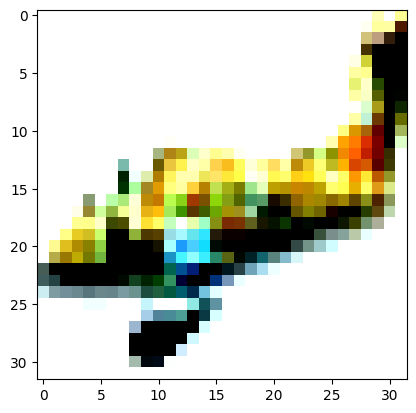

In [8]:
plt.imshow(cifar_val_ds[2][0].permute(1, 2, 0))

Creating simple dataloader

In [9]:
cutmix = v2.CutMix(alpha=1.0, num_classes=len(class_names))
mixup = v2.MixUp(alpha=0.2, num_classes=len(class_names))
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

In [10]:
BATCH_SIZE = 64

def collate_fn(batch):
    images = []
    labels = []
    for image, label in batch:
        image = torch.Tensor(image)
        images.append(image)
        labels.append(label)
    images = torch.stack(images, dim=0).float()
    labels = torch.Tensor(labels).long()
    return images, labels

def collate_fn_train(batch):
    return cutmix_or_mixup(collate_fn(batch))

cifar_train_dataloader = DataLoader(cifar_train_ds, collate_fn=collate_fn_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8)
cifar_val_dataloader = DataLoader(cifar_val_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)
cifar_test_dataloader = DataLoader(cifar_test_ds, collate_fn=collate_fn, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4)

Specifying loss

In [11]:
loss_fn_val = nn.CrossEntropyLoss()

def loss_fn(pred, soft_targets):
    soft_targets = soft_targets.clamp(min=1e-7)
    soft_targets = soft_targets / soft_targets.sum(dim=1, keepdim=True)
    log_probs = nn.functional.log_softmax(pred, dim=1)
    return -(soft_targets * log_probs).sum(dim=1).mean()

Specifying Image Classification model

In [ ]:
IMG_SIZE = 32
hidden_dim = 128
entities = 64

model = ImageClassifier(3, hidden_dim, len(class_names), entities, 3, 5).to(device)
torch.compile(model)

In [ ]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_name = f"bogomol-{num_parameters/1e+6:.1f}M({hidden_dim}, {entities})"

print(model_name)
summary(model, (3, IMG_SIZE, IMG_SIZE))

bogomol-61.7M(128, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GroupNorm-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 32, 32]           9,472
              GELU-3           [-1, 64, 32, 32]               0
            Linear-4              [-1, 81, 128]         524,416
              GELU-5              [-1, 81, 128]               0
         LayerNorm-6              [-1, 81, 128]             256
            Linear-7              [-1, 81, 128]             384
              Tanh-8              [-1, 81, 128]               0
MultiheadAttention-9  [[-1, 81, 128], [-1, 81, 81]]               0
             GELU-10              [-1, 81, 128]               0
           Linear-11               [-1, 81, 49]           6,321
             Tanh-12               [-1, 81, 49]               0
           Linear-13             [-1, 81, 3136]         404,544
            

In [ ]:
history = {
    "train_loss" : [float('inf')],
    "train_acc" : [0],
    "val_loss" : [float('inf')],
    "val_acc" : [0]
}

In [ ]:
def compute_accuracy(predictions: torch.Tensor, ground_truth: torch.Tensor) -> float:
    """
    Вычисляет точность предсказаний модели на CIFAR-10.

    Аргументы:
        predictions (torch.Tensor): Логиты сети (без softmax), размер [batch_size, num_classes].
        ground_truth (torch.Tensor): Истинные метки, размер [batch_size].

    Возвращает:
        float: Значение точности (accuracy) в процентах.
    """
    predicted_classes = predictions.argmax(dim=1)
    correct = (predicted_classes == ground_truth).sum().item()
    accuracy = correct / ground_truth.size(0)
    return accuracy

In [ ]:
def train(model, dataloader, optimizer, scheduler, scaler, accumulation_steps : int = 4):
    model.train()
    pbar = tqdm(dataloader, f"Train loss: {history['train_loss'][-1]:.3f}, acc: {history['train_acc'][-1]:.3f}")
    total_loss = 0
    cur_acc = 0
    total_acc = 0
    out_of_mem = 0

    for batch_idx, (images, labels) in enumerate(pbar):
        try:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with torch.autocast('cuda'):
                prediction = model(images)
                loss_value = loss_fn(prediction, labels)
            total_loss += loss_value.item()

            scaler.scale(loss_value/accumulation_steps).backward()

            #with torch.no_grad():
            #    cur_acc = compute_accuracy(prediction, labels)
            #    total_acc += cur_acc

            if (batch_idx+1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            if batch_idx % 10 == 0:
                pbar.set_description(f"Train loss: {loss_value.item():.3f}, acc: {cur_acc:.3f}")
        except RuntimeError as e:
            print(e)
            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e
        finally:
            scheduler.step()
    else:
        if (batch_idx+1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
        optimizer.zero_grad()
    mean_loss = total_loss/(batch_idx + 1)
    history['train_loss'].append(mean_loss)
    mean_acc = total_acc/(batch_idx + 1)
    history['train_acc'].append(mean_acc)
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches!")
    return mean_loss, mean_acc

@torch.no_grad()
def validate(model, dataloader):
    model.eval()
    pbar = tqdm(dataloader, f"Validation loss: {history['val_loss'][-1]:.3f}")
    total_loss = 0
    total_acc = 0
    out_of_mem = 0
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        try:
            prediction = model(images)
            loss_value = loss_fn_val(prediction, labels)
            total_loss += loss_value.item()
            cur_acc = compute_accuracy(prediction, labels)
            total_acc += cur_acc
            if batch_idx % 10 == 0:
                pbar.set_description(f"Validation loss: {loss_value.item():.3f}, acc: {cur_acc:.3f}")
        except RuntimeError as e:

            if 'out of memory' in str(e):
                out_of_mem += 1
                torch.cuda.empty_cache()
            else:
                raise e


    mean_loss = total_loss/(batch_idx + 1)
    history['val_loss'].append(mean_loss)
    mean_acc = total_acc/(batch_idx + 1)
    history['val_acc'].append(mean_acc)
    if out_of_mem:
        print(f"Memory overflow occurred in {out_of_mem}/{batch_idx+1} batches!")
    return mean_loss, mean_acc

In [ ]:
def configure_optimizer(
    model,
    base_lr=3e-4,
    weight_decay=0.1,
    betas=(0.9, 0.999),
    warmup_epochs=5,
    total_epochs=100,
    steps_per_epoch=1000
):
    # Group parameters
    decay_params, no_decay_params = [], []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if param.ndim == 1 or name.endswith(".bias") or "norm" in name.lower():
            no_decay_params.append(param)
        else:
            decay_params.append(param)

    param_groups = [
        {"params": decay_params, "weight_decay": weight_decay},
        {"params": no_decay_params, "weight_decay": 0.0},
    ]

    # AdamW optimizer
    optimizer = AdamW(param_groups, lr=base_lr, betas=betas)

    # Scheduler with linear warmup + cosine decay
    def lr_lambda(current_step):
        if current_step < warmup_epochs*steps_per_epoch:
            return current_step / max(1, warmup_epochs*steps_per_epoch)
        progress = float(current_step - warmup_epochs*steps_per_epoch) / max(1, (total_epochs - warmup_epochs)*steps_per_epoch)
        return 0.5 * (1.0 + torch.cos(torch.tensor(progress * torch.pi)))

    scheduler = LambdaLR(optimizer, lr_lambda)

    return optimizer, scheduler

In [ ]:
EPOCHS = 100
optimizer, scheduler = configure_optimizer(model, base_lr=3e-4, warmup_epochs=EPOCHS//20, total_epochs=EPOCHS, steps_per_epoch=len(cifar_train_dataloader))
scaler = torch.GradScaler(device)
checkpoint_pth = './models'
best_val_loss = float('inf')

for i in range(EPOCHS):
    print(f"Training epoch: {i+1}/{EPOCHS}")
    train_loss, train_acc = train(model, cifar_train_dataloader, optimizer, scheduler, scaler)
    print(f"Average training loss: {train_loss:.3f}, accuracy: {train_acc:.3f}")
    print(f"Learning rate: {scheduler.get_last_lr()[0]}, gradient scale: {scaler.get_scale()}")
    val_loss, val_acc = validate(model, cifar_val_dataloader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = model.state_dict()
        torch.save(best_params, os.path.join(checkpoint_pth, model_name+'.pth'))
    print(f"Average validation loss: {val_loss:.3f}, accuracy: {val_acc:.3f}")
    print("-"*80)
    if train_loss is torch.nan:
        break


In [ ]:
best_model = model
best_model.load_state_dict(torch.load(os.path.join(checkpoint_pth, model_name+'.pth'), weights_only=True))
best_model.eval()

Model loss

In [ ]:
plots_pth = './plots'

plt.plot(history['train_loss'], label="Train loss")
plt.plot(history['val_loss'], label="Validation loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model loss")
plt.savefig(os.path.join(plots_pth, f'{model_name}-loss.png'))

Model accuracy

In [ ]:
plt.plot(history['train_acc'], label="Train accuracy")
plt.plot(history['val_acc'], label="Validation accuracy")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model accuracy")
plt.savefig(os.path.join(plots_pth, f'{model_name}-acc.png'))

In [ ]:
test_loss, test_acc = validate(best_model, cifar_test_dataloader)

In [ ]:
with open('model.txt', 'w') as f:
    f.write(f"Train accuracy : {max(history['train_acc'])}, loss : {min(history['train_loss'])}\n")
    f.write(f"Validation accuracy : {max(history['val_acc'])}, loss : {min(history['val_loss'])}\n")
    f.write(f"Test accuracy : {test_acc}, loss : {test_loss}\n")